# Deep Learning Models

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import json
import joblib
import re
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

[nltk_data] Downloading package punkt to /home/mfain/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [115]:
def cleanText(text):
    text = text.lower()

    # Remove links
    text = re.sub(r"http\S*|\S*\.com\S*|\S*www\S*", " ", text)

    # Remove @mentions
    text = re.sub(r"\s@\S+", " ", text)

    # Remove all punctuation
    punctuation_table = str.maketrans("", "", string.punctuation)
    text = text.translate(punctuation_table)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [2]:
df = pd.read_csv('full_dataset/full_dataset.csv')
df

,emotion,original_text,text_tokens,preprocessed_text
0,happiness,"During the period of falling in love, each tim...","['period', 'falling', 'love', 'time', 'met', '...",period falling love time met especially met lo...
1,fear,When I was involved in a traffic accident.,"['involved', 'traffic', 'accident']",involved traffic accident
2,anger,When I was driving home after several days of...,"['driving', 'home', 'several', 'day', 'hard', ...",driving home several day hard work motorist ah...
3,sadness,When I lost the person who meant the most to me.,"['lost', 'person', 'meant']",lost person meant
4,disgust,The time I knocked a deer down - the sight of ...,"['time', 'knocked', 'deer', 'sight', 'animal',...",time knocked deer sight animal injury helpless...
...,...,...,...,...
9801,shame,He gets real humiliated and has to leave .,"['get', 'real', 'humiliated', 'leave']",get real humiliated leave
9802,shame,They aimed for higher status jobs and felt hum...,"['aimed', 'higher', 'status', 'job', 'felt', '...",aimed higher status job felt humiliated unempl...
9803,shame,He cursed his lack of self-control ; he knew t...,"['cursed', 'lack', 'selfcontrol', 'knew', 'old...",cursed lack selfcontrol knew old biddy seen fe...
9804,shame,Sometimes I've thought I 'll never forget wha...,"['sometimes', 'ive', 'thought', 'never', 'forg...",sometimes ive thought never forget happened co...


In [3]:
df['emotion'].value_counts()

emotion
sadness      1614
anger        1551
happiness    1549
fear         1494
shame        1185
disgust      1158
guilt        1043
surprise      212
Name: count, dtype: int64

In [4]:
#check if the data is balanced or not
df['emotion'].value_counts() / df.shape[0] * 100

emotion
sadness      16.459311
anger        15.816847
happiness    15.796451
fear         15.235570
shame        12.084438
disgust      11.809096
guilt        10.636345
surprise      2.161942
Name: count, dtype: float64

In [5]:
df.isnull().sum()

emotion              0
original_text        0
text_tokens          0
preprocessed_text    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(9806, 4)

Check for rows with the same text but different emotions

In [8]:
df[df['original_text'].duplicated() == True]

,emotion,original_text,text_tokens,preprocessed_text


In [9]:
df[df['original_text'] == 'Friends who torture animals.']

,emotion,original_text,text_tokens,preprocessed_text
36,anger,Friends who torture animals.,"['friend', 'torture', 'animal']",friend torture animal


In [10]:
#remove duplicated text
indexes = df[df['original_text'].duplicated() ==  True].index
df.drop(indexes, axis=0, inplace=True)
df.shape

(9806, 4)

## Splitting the data

A stratified split was used in order to ensure class balance within the train, test and validation set.

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, test_valid_index in split.split(df, df['emotion']):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set['emotion']):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

In [12]:
train_set.shape, test_set.shape, valid_set.shape

((5883, 4), (1961, 4), (1962, 4))

In [13]:
#check if train data is balanced
train_set['emotion'].value_counts() / train_set.shape[0] * 100

emotion
sadness      16.454190
anger        15.825259
happiness    15.791263
fear         15.230325
shame        12.085671
disgust      11.813700
guilt        10.640830
surprise      2.158763
Name: count, dtype: float64

In [14]:
#check if test data is balanced
test_set['emotion'].value_counts() / test_set.shape[0] * 100

emotion
sadness      16.471188
happiness    15.808261
anger        15.808261
fear         15.247323
shame        12.085671
disgust      11.779704
guilt        10.606833
surprise      2.192759
Name: count, dtype: float64

In [15]:
#check if validation data is balanced
valid_set['emotion'].value_counts() / valid_set.shape[0] * 100

emotion
sadness      16.462793
happiness    15.800204
anger        15.800204
fear         15.239551
shame        12.079511
disgust      11.824669
guilt        10.652396
surprise      2.140673
Name: count, dtype: float64

In [16]:
x_train = train_set['preprocessed_text']
y_train = train_set['emotion']

x_test = test_set['preprocessed_text']
y_test = test_set['emotion']

x_valid = valid_set['preprocessed_text']
y_valid = valid_set['emotion']

## Preparing for Modeling

In [17]:
# encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_valid = le.transform(y_valid)

In [18]:
n_classes = len(le.classes_)
le.classes_

array(['anger', 'disgust', 'fear', 'guilt', 'happiness', 'sadness',
       'shame', 'surprise'], dtype=object)

In [19]:
# convert the labels to vectors (binary class matrix)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

In [20]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Tokenizing

In [21]:
tokenizer = Tokenizer(oov_token='UNK') #set out-of-vocab tokens to 'UNK'
tokenizer.fit_on_texts(pd.concat([x_train, x_valid], axis=0))

In [92]:
#word index - a dictionary of words and their uniquely assigned integers
tokenizer.word_index['UNK'], tokenizer.word_index['friend'], tokenizer.word_index['mother']

(1, 2, 10)

In [97]:
#word counts- a dictionary of words and their counts
tokenizer.word_counts['friend'], tokenizer.word_counts['mother']

(1121, 356)

Let's check if there are any out-of-vocabulary tokens

In [24]:
'UNK' in tokenizer.word_counts.keys()

False

In [25]:
#document count - a dictionary of words and how many documents each appeared in
#in this dataset the output will be the number of rows
tokenizer.document_count

7845

In [35]:
#word docs - an integer count of the total number of documents(or rows) that were used to fit the Tokenizer
tokenizer.word_docs['use']

38

Example of what will be done on the entire dataset

In [36]:
x_train[0]

'period falling love time met especially met long time'

In [37]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(x_train[0].split())

[[488], [935], [98], [5], [111], [359], [111], [79], [5]]

In [38]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(x_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
#the sentence contains 9 words and the size of the vocabulary is 10605
tokenizer.texts_to_matrix(x_train[0].split()).shape

(9, 10558)

In [40]:
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
sequences_valid = tokenizer.texts_to_sequences(x_valid)

In [41]:
sequences_train[:2]

[[2,
  33,
  2721,
  387,
  1986,
  1987,
  119,
  26,
  1988,
  4972,
  442,
  1987,
  44,
  349,
  2721,
  284,
  139,
  1986,
  2288,
  2289,
  139,
  2721,
  2288],
 [529, 788, 226, 214, 2, 1118, 1748, 788]]

## Add Padding

In [42]:
test_set.shape

(1961, 4)

In [43]:
max(train_set['text_tokens'].apply(len))

706

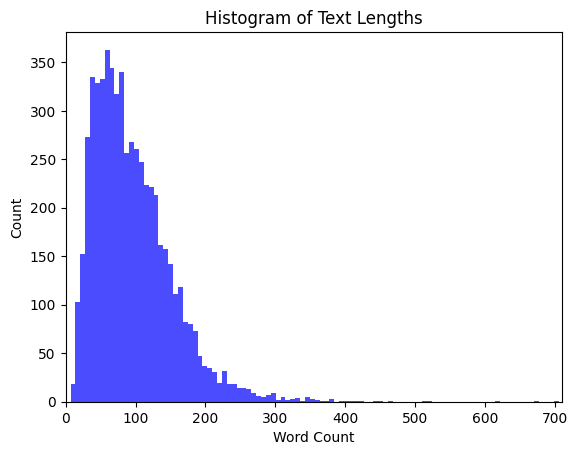

In [44]:
train_text_length = train_set['text_tokens'].apply(len)

plt.hist(train_text_length, bins=100, color='blue', alpha=0.7)
plt.xlim(0, 710)
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Histogram of Text Lengths')
plt.show()

In [45]:
(train_text_length > 300).sum()

45

As there are very few texts larger than 300 words, we will take that value as max_length. The texts which have greater length than 300 will be truncated to fit the max_length size, others will be padded.

In [46]:
MAX_LEN = 300

In [47]:
x_train = pad_sequences(sequences_train, maxlen=MAX_LEN, truncating='pre')
x_test = pad_sequences(sequences_test, maxlen=MAX_LEN, truncating='pre')
x_valid = pad_sequences(sequences_valid, maxlen=MAX_LEN, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 10558


In [48]:
#before
sequences_train[1]

[529, 788, 226, 214, 2, 1118, 1748, 788]

In [49]:
#after
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Word Embeddings

We are using GloVe pre-trained word vectors. They can be downloaded on: https://nlp.stanford.edu/projects/glove/. We used 'glove.6B'. Let's also clarify some variables that will be used:
- path_to_glove - file path to the GloVe word vectors file (downloaded from the official website)
- num_tokens - size of the vocabulary (number of unique words in our dataset)
- embedding_dim - dimensionality of the word vectors (hyperparameter)
- hits - counter for the number of words that are found in the embeddings_index dictionary
- misses - counter for the number of words that are not found in the embeddings_index dictionary
- embeddings_index - dictionary that will store the word vectors, with the words as keys and the word vectors as values

In [50]:
path_to_glove = 'downloads/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #could be changed to better fit the model
hits = 0
misses = 0
embeddings_index = {}

In [52]:
# read word vectors
with open(path_to_glove, encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        # this includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 9582 words (975 misses)


## Modeling

In [70]:
params = {'dropout': 0.3,
          'rec_dropout': 0.3,
          'learning_rate': 0.006,
          'patience': 4 }

In [67]:
model = Sequential()
model.add(Embedding(vocabSize, embedding_dim, input_length=x_train.shape[1],
                    weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(units=256, dropout=params['dropout'], recurrent_dropout=params['rec_dropout'], return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, dropout=params['dropout'], recurrent_dropout=params['rec_dropout'])))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=params['learning_rate']),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 200)          2111600   
                                                                 
 bidirectional_6 (Bidirecti  (None, 300, 512)          935936    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 3705976 (14.14 MB)
Trainable params: 1594376 (6.08 MB)
Non-trainable params: 2111600 (8.06 MB)
_________________________________________________________________


In [59]:
#plot_model(model, show_shapes=True)

In [68]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=params['patience'],
    restore_best_weights=True,
)

In [65]:
# fit model
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
23/23 [==============================] - 52s 2s/step - loss: 1.7322 - accuracy: 0.3514 - val_loss: 1.4439 - val_accuracy: 0.4847
Epoch 2/30
23/23 [==============================] - 45s 2s/step - loss: 1.2512 - accuracy: 0.5552 - val_loss: 1.1534 - val_accuracy: 0.6035
Epoch 3/30
23/23 [==============================] - 45s 2s/step - loss: 1.0590 - accuracy: 0.6264 - val_loss: 1.0618 - val_accuracy: 0.6177
Epoch 4/30
23/23 [==============================] - 44s 2s/step - loss: 0.8978 - accuracy: 0.6859 - val_loss: 1.0139 - val_accuracy: 0.6555
Epoch 5/30
23/23 [==============================] - 45s 2s/step - loss: 0.7818 - accuracy: 0.7236 - val_loss: 0.9716 - val_accuracy: 0.6764
Epoch 6/30
23/23 [==============================] - 45s 2s/step - loss: 0.6683 - accuracy: 0.7634 - val_loss: 1.0676 - val_accuracy: 0.6600
Epoch 7/30
23/23 [==============================] - 44s 2s/step - loss: 0.5777 - accuracy: 0.8004 - val_loss: 1.0844 - val_accuracy: 0.6774
Epoch 8/30
23/23 [==

## Save model, tokenizer and label encoder

In [71]:
model.save('models/bilstm_model.keras')

In [87]:
tokenizer_json = tokenizer.to_json()
with io.open('models/tokenizer_lstm.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [100]:
joblib.dump(le, 'models/le_lstm.pkl')

['models/le_lstm.pkl']

## Validation

In [72]:
#print the overall loss and accuracy
model.evaluate(x_valid, y_valid, verbose=1) 

62/62 [==============================] - 7s 118ms/step - loss: 1.0324 - accuracy: 0.6488


[1.0324114561080933, 0.6488277316093445]

In [73]:
#print the overall loss and accuracy
model.evaluate(x_test, y_test, verbose=1) 

62/62 [==============================] - 7s 120ms/step - loss: 0.9798 - accuracy: 0.6517


[0.979828417301178, 0.6517083048820496]

In [74]:
predictions = model.predict(x_test)
y_pred = predictions.argmax(axis=-1)

print("Classification report:\n", classification_report(le.transform(test_set['emotion']), y_pred, target_names=le.classes_))

62/62 [==============================] - 8s 119ms/step
Classification report:
               precision    recall  f1-score   support

       anger       0.54      0.64      0.58       310
     disgust       0.67      0.58      0.62       231
        fear       0.71      0.82      0.76       299
       guilt       0.53      0.38      0.44       208
   happiness       0.71      0.78      0.74       310
     sadness       0.66      0.74      0.70       323
       shame       0.68      0.43      0.53       237
    surprise       0.91      0.91      0.91        43

    accuracy                           0.65      1961
   macro avg       0.67      0.66      0.66      1961
weighted avg       0.65      0.65      0.64      1961



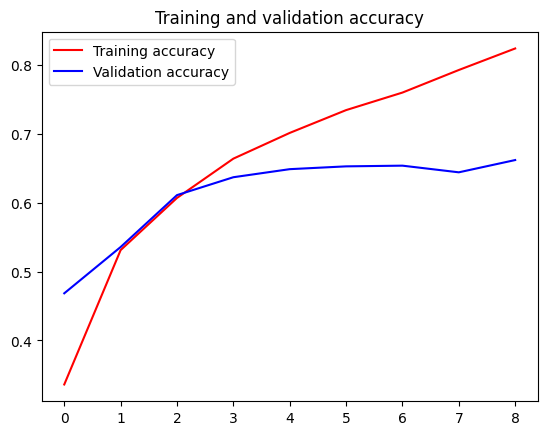

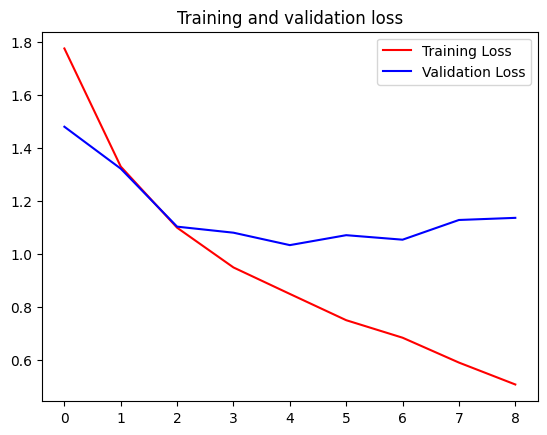

In [75]:
# Visualize Loss & Accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

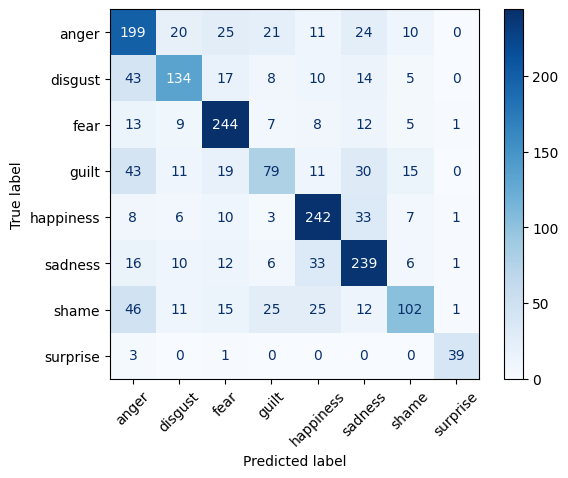

In [76]:
cm = confusion_matrix(y_test.argmax(axis=-1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

## Custom Example

In [89]:
with open('models/tokenizer_lstm.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [103]:
loaded_le = joblib.load('models/le_lstm.pkl')

In [106]:
loaded_model = load_model('models/bilstm_model.keras')

In [121]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]

for sentence in sentences:
    print(sentence)
    sentence = ' '.join(cleanText(sentence))
    sentence = loaded_tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=MAX_LEN, truncating='pre')
    result = loaded_le.inverse_transform(np.argmax(loaded_model.predict(sentence), axis=-1))[0]
    proba =  np.max(loaded_model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 0s 91ms/step
happiness : 0.9735988974571228


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 0s 93ms/step
anger : 0.6219926476478577


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 0s 97ms/step
fear : 0.42250266671180725


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 0s 93ms/step
surprise : 0.968241810798645


